In [1]:
import pandas as pd
import numpy as np

In [2]:
news_df = pd.read_pickle("cleaned_news.pkl")
news_ids = set(news_df["newsID"])

In [12]:

# Load behaviors data
behaviors_cols = ["impression_id", "user_id", "time", "history", "impressions"]
behaviors_df = pd.read_csv("train_data/behaviors.tsv", sep="\t", header=None, names=behaviors_cols)
display(behaviors_df.head())
display(len(behaviors_df))

,impression_id,user_id,time,history,impressions
0,1,U87243,11/10/2019 11:30:54 AM,N8668 N39081 N65259 N79529 N73408 N43615 N2937...,N78206-0 N26368-0 N7578-0 N58592-0 N19858-0 N5...
1,2,U598644,11/12/2019 1:45:29 PM,N56056 N8726 N70353 N67998 N83823 N111108 N107...,N47996-0 N82719-0 N117066-0 N8491-0 N123784-0 ...
2,3,U532401,11/13/2019 11:23:03 AM,N128643 N87446 N122948 N9375 N82348 N129412 N5...,N103852-0 N53474-0 N127836-0 N47925-1
3,4,U593596,11/12/2019 12:24:09 PM,N31043 N39592 N4104 N8223 N114581 N92747 N1207...,N38902-0 N76434-0 N71593-0 N100073-0 N108736-0...
4,5,U239687,11/14/2019 8:03:01 PM,N65250 N122359 N71723 N53796 N41663 N41484 N11...,N76209-0 N48841-0 N67937-0 N62235-0 N6307-0 N3...


2232748

In [3]:
# Check for duplicates
duplicate_impressions = behaviors_df.duplicated(subset=["impression_id"]).sum()
print(f"Duplicate impression IDs: {duplicate_impressions}")

# Check missing values
print("\nMissing values in behaviors data:")
print(behaviors_df.isnull().sum())

Duplicate impression IDs: 0

Missing values in behaviors data:
impression_id        0
user_id              0
time                 0
history          46065
impressions          0
dtype: int64


In [5]:
# Total number of rows
total_rows = len(behaviors_df)

# Number of missing history values
missing_history_count = behaviors_df['history'].isna().sum()

# Percentage missing
missing_history_pct = (missing_history_count / total_rows) * 100

print(f"Missing history: {missing_history_count} rows ({missing_history_pct:.2f}%)")


Missing history: 46065 rows (2.06%)


In [7]:
missing_history_df = behaviors_df[behaviors_df['history'].isna()]
# Unique users with missing history
unique_users_missing = missing_history_df['user_id'].nunique()
print(f"Unique users with missing history: {unique_users_missing}")

# Click rate (optional — only if you've already exploded impressions)
if 'clicked' in missing_history_df.columns:
    click_rate = missing_history_df['clicked'].mean()
    print(f"Click rate for users with missing history: {click_rate:.2%}")

# Count by timestamp (if timestamp column exists)
if 'time' in missing_history_df.columns:
    print(missing_history_df['time'].value_counts().head())


Unique users with missing history: 12857
time
11/13/2019 12:43:55 PM    4
11/13/2019 12:13:56 PM    4
11/14/2019 9:18:56 AM     4
11/12/2019 5:26:43 AM     4
11/14/2019 1:28:28 PM     4
Name: count, dtype: int64


Even though about 2% of the rows in my behaviors_df dataset have missing history values, I decided to keep them for this stage of the project. Right now, I'm focused on measuring headline click-through rates (CTR) — not building a personalized recommendation model.

Since CTR is calculated at the headline level, it doesn’t really matter whether the user has a reading history or not. In fact, keeping these rows actually helps me include more impressions and clicks, which makes my headline CTR stats more reliable.

Later on, if I shift focus to user behavior or personalization, I might filter or treat these rows differently. But for now, they’re staying in

In [15]:
import pandas as pd

# Only sample read the first 10,000 rows
behaviors_df = pd.read_csv(
    'train_data/behaviors.tsv',
    sep='\t',
    header=None,
    names=['impression_id', 'user_id', 'time', 'history', 'impressions'],
    nrows=10000
)
len(behaviors_df)

10000

The behaviors_df dataset contains around 2 million rows, and each row includes a list of article impressions in the form of strings like "N333-0 N444-1 N555-0". Each item represents an article shown to the user (a news_id) and whether it was clicked (1 for clicked, 0 for not clicked).

When you expand this format so that each impression becomes its own row, the dataset grows significantly—potentially into tens of millions of rows. To avoid overwhelming memory and overloading the machine, I started with a sample of 10,000 rows to test and validate the expansion logic.

The plan is to roll this out in larger batches, likely in increments of 100,000 rows at a time. This way, I can scale the analysis gradually while avoiding performance issues. It allows me to explore headline-level click-through rates (CTR) in a controlled, resource-efficient way.

In [17]:
impressions_expanded = []

for _, row in behaviors_df.iterrows():
    try:
        impressions = row['impressions'].split()
        for item in impressions:
            if '-' in item:
                news_id, clicked = item.split('-')
                impressions_expanded.append({
                    'impression_id': row['impression_id'],
                    'user_id': row['user_id'],
                    'news_id': news_id,
                    'clicked': int(clicked)
                })
    except Exception as e:
        print(f"Skipping row due to error: {e}")
        continue
impressions_expanded

[{'impression_id': 1, 'user_id': 'U87243', 'news_id': 'N78206', 'clicked': 0},
 {'impression_id': 1, 'user_id': 'U87243', 'news_id': 'N26368', 'clicked': 0},
 {'impression_id': 1, 'user_id': 'U87243', 'news_id': 'N7578', 'clicked': 0},
 {'impression_id': 1, 'user_id': 'U87243', 'news_id': 'N58592', 'clicked': 0},
 {'impression_id': 1, 'user_id': 'U87243', 'news_id': 'N19858', 'clicked': 0},
 {'impression_id': 1, 'user_id': 'U87243', 'news_id': 'N58258', 'clicked': 0},
 {'impression_id': 1, 'user_id': 'U87243', 'news_id': 'N18478', 'clicked': 0},
 {'impression_id': 1, 'user_id': 'U87243', 'news_id': 'N2591', 'clicked': 0},
 {'impression_id': 1, 'user_id': 'U87243', 'news_id': 'N97778', 'clicked': 0},
 {'impression_id': 1, 'user_id': 'U87243', 'news_id': 'N32954', 'clicked': 0},
 {'impression_id': 1, 'user_id': 'U87243', 'news_id': 'N94157', 'clicked': 1},
 {'impression_id': 1, 'user_id': 'U87243', 'news_id': 'N39404', 'clicked': 0},
 {'impression_id': 1, 'user_id': 'U87243', 'news_id': 

In the behaviors dataset, each row can contain multiple article impressions in the form of strings like `"N1234-1 N2345-0"`. That means a single row represents a full impression session, not individual article views.

To analyze things like headline click-through rate (CTR), I needed to split or expand those multi-item strings so that each row would represent one article impression. This way, I can calculate how each article performs on its own — which wouldn’t be possible if they were all bundled together in one string.

This means the user saw 3 articles during a session, and clicked only one of them. But since they're all bundled into a single row, it's impossible to calculate individual headline performance.

In the raw `behaviors_df`, each row contains a list of article impressions like`"N333-0 N444-1 N555-0"` but as shown above when expanded these open up to show impressions and click per user and per article and most importantly the click-through rate (CTR) for each headline. This matters because I'm analyzing headline performance — and in this dataset, each `news_id` is tied to a specific headline. So CTR per `news_id` is essentially CTR per headline.

In [18]:
impressions_df = pd.DataFrame(impressions_expanded)
print(f"Expanded to {len(impressions_df)} impression records")

Expanded to 371707 impression records


In [19]:
# Check for invalid news IDs (not in news_df)
invalid_news_ids = impressions_df[~impressions_df["news_id"].isin(news_ids)]
print(f"Impression records with invalid news IDs: {len(invalid_news_ids)}")

Impression records with invalid news IDs: 0


In [20]:
# Check click distribution
clicks = impressions_df["clicked"].sum()
total = len(impressions_df)
print(f"\nOverall CTR: {clicks/total:.4f} ({clicks} clicks out of {total} impressions)")


Overall CTR: 0.0410 (15247 clicks out of 371707 impressions)


This gives us a baseline where 4.1% is our benchmark for evaluating which headlines perform above or below average.

- By headline: which ones score above 4.1%?

- By category: do some consistently outperform others?

- By user segment (returning vs. new): does history matter?

In [21]:
# Check for articles with too few impressions (unreliable CTR)
article_impressions = impressions_df.groupby("news_id").size()
low_impression_articles = (article_impressions < 5).sum()
print(f"Articles with fewer than 5 impressions: {low_impression_articles}")

Articles with fewer than 5 impressions: 5711


In [22]:

# Check for extreme CTRs (potential data issues)
article_ctrs = impressions_df.groupby("news_id")["clicked"].mean()
suspicious_ctrs = ((article_ctrs == 0) | (article_ctrs > 0.7)).sum()
print(f"Articles with suspicious CTRs (0 or >70%): {suspicious_ctrs}")

# Potential adjustments based on exploration:
# 1. Filter out articles with too few impressions (e.g., < 10)
# 2. Investigate articles with extreme CTRs
# 3. Set minimum threshold for impression count when calculating CTR

Articles with suspicious CTRs (0 or >70%): 7079


In [23]:
# Create a full article_ctr DataFrame from your impression data
article_ctr = impressions_df.groupby("news_id").agg({
    "clicked": ["sum", "count"]
})

# Rename columns for clarity
article_ctr.columns = ["clicks", "impressions"]
article_ctr = article_ctr.reset_index()

# Calculate CTR
article_ctr["ctr"] = article_ctr["clicks"] / article_ctr["impressions"]

# Filter out articles with too few impressions
min_impressions = 5
filtered_article_ctr = article_ctr[article_ctr["impressions"] >= min_impressions].copy()
print(f"Filtered out {len(article_ctr) - len(filtered_article_ctr)} articles with fewer than {min_impressions} impressions")
print(f"Remaining articles: {len(filtered_article_ctr)}")

Filtered out 5711 articles with fewer than 5 impressions
Remaining articles: 3891


In [24]:
# Filter out articles with suspicious CTRs
clean_article_ctr = filtered_article_ctr[
    (filtered_article_ctr["ctr"] > 0) & 
    (filtered_article_ctr["ctr"] <= 0.7)
].copy()
print(f"Filtered out {len(filtered_article_ctr) - len(clean_article_ctr)} articles with extreme CTRs")
print(f"Final clean dataset: {len(clean_article_ctr)} articles")

Filtered out 1610 articles with extreme CTRs
Final clean dataset: 2281 articles


In [27]:
clean_article_ctr.columns

Index(['news_id', 'clicks', 'impressions', 'ctr'], dtype='object')

In [28]:
news_df.columns

Index(['newsID', 'category', 'subcategory', 'title', 'abstract'], dtype='object')

In [ ]:
# 1. Check the first few values from both columns
print("Sample news_id values from clean_article_ctr:")
print(clean_article_ctr['news_id'].head())

print("\nSample newsID values from news_df:")
print(news_df['newsID'].head())

# 2. Check data types
print("\nData types:")
print(f"clean_article_ctr['news_id']: {clean_article_ctr['news_id'].dtype}")
print(f"news_df['newsID']: {news_df['newsID'].dtype}")

# 3. Fix potential issues by standardizing both columns
# Convert to string and standardize case
clean_article_ctr['news_id'] = clean_article_ctr['news_id'].astype(str).str.strip()
news_df['newsID'] = news_df['newsID'].astype(str).str.strip()

# 4. Check if there are any common values
common_values = set(clean_article_ctr['news_id']).intersection(set(news_df['newsID']))
print(f"\nNumber of common values: {len(common_values)}")
if len(common_values) > 0:
    print("First few common values:", list(common_values)[:5])
else:
    print("No common values found!")

Sample news_id values from clean_article_ctr:
0     N100006
7     N100073
11     N10012
13    N100149
17    N100173
Name: news_id, dtype: object

Sample newsID values from news_df:
N88753  lifestyle  lifestyleroyals             The Brands Queen Elizabeth, Prince Charles, an...
N45436  news       newsscienceandtechnology      Walmart Slashes Prices on Last-Generation iPads
N23144  health     weightloss                                      50 Worst Habits For Belly Fat
N86255  health     medical                     Dispose of unwanted prescription drugs during ...
N93187  news       newsworld                   The Cost of Trump's Aid Freeze in the Trenches...
Name: newsID, dtype: object

Data types:
clean_article_ctr['news_id']: object
news_df['newsID']: object

Number of common values: 0
No common values found!


In [32]:
# Fix the news dataframe loading
news_df = pd.read_csv("train_data/news.tsv", sep="\t", header=None)
news_cols = ["newsID", "category", "subcategory", "title", "abstract", "url", "title_entities", "abstract_entities"]

# Check the first few rows to see the structure
print("Original news_df structure:")
print(news_df.head())

# Assign column names properly based on the actual structure
if len(news_df.columns) == 5:  # If it's already correctly parsed
    news_df.columns = news_cols
else:  # If it's a single column with tab characters
    print("Restructuring the dataframe...")
    # Try a different approach to split the data
    news_df = pd.read_csv("train_data/news.tsv", sep="\t", header=None, names=news_cols, 
                          engine='python', quoting=3)

# Check again after fixing
print("\nFixed news_df structure:")
print(news_df.head())
print(f"Shape of news_df: {news_df.shape}")

# Now try to find common values again
news_df['newsID'] = news_df['newsID'].astype(str).str.strip()
common_values = set(clean_article_ctr['news_id']).intersection(set(news_df['newsID']))
print(f"\nNumber of common values after fixing: {len(common_values)}")
if len(common_values) > 0:
    print("First few common values:", list(common_values)[:5])

# Try the merge again with the fixed dataframe
articles_with_metadata = clean_article_ctr.merge(
    news_df,
    left_on="news_id",
    right_on="newsID",
    how="inner"
)

print(f"Articles with complete metadata: {len(articles_with_metadata)}")


Original news_df structure:
        0          1                         2  \
0  N88753  lifestyle           lifestyleroyals   
1  N45436       news  newsscienceandtechnology   
2  N23144     health                weightloss   
3  N86255     health                   medical   
4  N93187       news                 newsworld   

                                                   3  \
0  The Brands Queen Elizabeth, Prince Charles, an...   
1    Walmart Slashes Prices on Last-Generation iPads   
2                      50 Worst Habits For Belly Fat   
3  Dispose of unwanted prescription drugs during ...   
4  The Cost of Trump's Aid Freeze in the Trenches...   

                                                   4  \
0  Shop the notebooks, jackets, and more that the...   
1  Apple's new iPad releases bring big deals on l...   
2  These seemingly harmless habits are holding yo...   
3                                                NaN   
4  Lt. Ivan Molchanets peeked over a parapet of s...  

In [33]:
articles_with_metadata.head()

,news_id,clicks,impressions,ctr,newsID,category,subcategory,title,abstract,url,title_entities,abstract_entities
0,N100006,1,21,0.047619,N100006,travel,ustravel,30 Ultimate Things to Do in New York City,Consider this your New York City bucket list.,https://assets.msn.com/labs/mind/BBWujUo.html,"[{""Label"": ""New York City"", ""Type"": ""G"", ""Wiki...","[{""Label"": ""New York City"", ""Type"": ""G"", ""Wiki..."
1,N100073,78,1051,0.074215,N100073,lifestyle,lifestyleroyals,Why Prince Harry Wore His Remembrance Poppy Di...,Why Prince Harry's Poppy Was Worn on His Cap,https://assets.msn.com/labs/mind/BBWByOC.html,"[{""Label"": ""Prince Harry, Duke of Sussex"", ""Ty...","[{""Label"": ""Prince Harry, Duke of Sussex"", ""Ty..."
2,N10012,8,302,0.026490,N10012,lifestyle,lifestylehomeandgarden,200 Shocking Home Photos You Have to See,"We know a good DIY project when we see it, but...",https://assets.msn.com/labs/mind/AAJHHxI.html,[],"[{""Label"": ""DIY (magazine)"", ""Type"": ""M"", ""Wik..."
3,N100149,1,18,0.055556,N100149,sports,baseball_mlb,Giants hire Cubs assistant to be their new gen...,The Giants said Sunday they have hired Scott H...,https://assets.msn.com/labs/mind/BBWy4N0.html,"[{""Label"": ""San Francisco Giants"", ""Type"": ""O""...","[{""Label"": ""San Francisco Giants"", ""Type"": ""O""..."
4,N100173,1,51,0.019608,N100173,health,healthnews,Britney Spears Reveals Her Secret Cheat Meal I...,"On November 10, Britney Spears, world-class po...",https://assets.msn.com/labs/mind/BBWEWqW.html,"[{""Label"": ""Britney Spears"", ""Type"": ""P"", ""Wik...","[{""Label"": ""Britney Spears"", ""Type"": ""P"", ""Wik..."



CTR by Category:
                    ctr                
                   mean       std count
category                               
weather        0.106795  0.084323    34
video          0.085797  0.066596    71
sports         0.075770  0.075865   329
news           0.064110  0.065707   683
tv             0.063316  0.058029    79
music          0.062713  0.070316    67
foodanddrink   0.055111  0.059190   159
health         0.054828  0.041775   152
lifestyle      0.046844  0.036656   207
finance        0.042589  0.035355   189
entertainment  0.042157  0.065647    61
movies         0.041231  0.034080    45
autos          0.040458  0.039885   104
travel         0.034642  0.031962   101


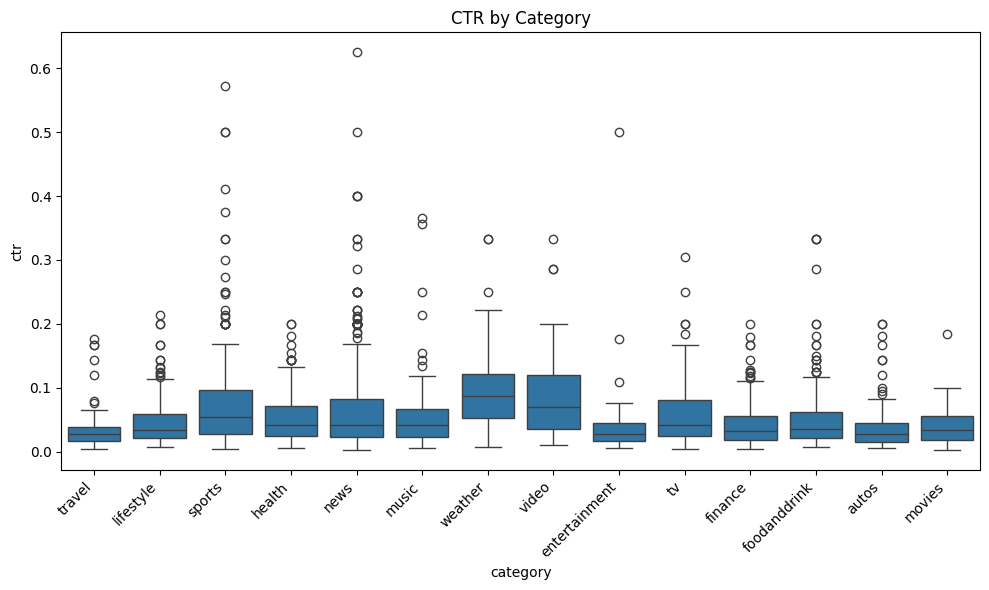

In [34]:
# Calculate CTR by category
category_ctr = articles_with_metadata.groupby("category").agg({
    "ctr": ["mean", "std", "count"]
}).sort_values(("ctr", "mean"), ascending=False)

print("\nCTR by Category:")
print(category_ctr)

# Visualize CTR by category
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x="category", y="ctr", data=articles_with_metadata)
plt.title("CTR by Category")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("ctr_by_category.png")
plt.show()

Key Insights from the CTR Analysis
The boxplot and statistical summary reveal clear patterns in how users engage with different news categories:

- Weather content leads engagement: Weather has the highest mean CTR (10.7%), suggesting users are highly motivated to click on weather-related news, likely due to its practical utility and immediate relevance to daily life.
- Video and sports content perform strongly: Video (8.6% CTR) and sports (7.6% CTR) rank second and third in engagement, indicating high interest in multimedia content and sports news.
- News and TV make up the middle tier: General news (6.4% CTR) and TV-related content (6.3% CTR) show moderate but consistent engagement.
- content has the lowest mean CTR (3.5%)

- The boxplot shows weather, sports, and news categories have numerous outliers with significantly higher CTRs than their category averages, suggesting certain stories within these categories can dramatically outperform typical content.

Practical Implications
These findings have several implications for news recommendation and content strategy:

Content prioritization: Higher-CTR categories like weather, video, and sports might deserve more prominent placement in news feeds.
Identifying opportunities: Categories with high outliers (like sports) suggest opportunities to analyze what makes certain articles perform exceptionally well.
The utility factor: Categories with practical, immediate utility (weather, sports scores) tend to perform better than more general interest categories.

In [35]:
# Add headline feature analysis
# Feature 1: Headline length
articles_with_metadata["title_length"] = articles_with_metadata["title"].str.len()
articles_with_metadata["word_count"] = articles_with_metadata["title"].str.split().str.len()

# Feature 2: Contains numbers
articles_with_metadata["has_number"] = articles_with_metadata["title"].str.contains(r"\d").astype(int)

# Feature 3: Is a question
articles_with_metadata["is_question"] = articles_with_metadata["title"].str.endswith("?").astype(int)

# Calculate correlation between features and CTR
feature_cols = ["title_length", "word_count", "has_number", "is_question"]
correlations = articles_with_metadata[feature_cols + ["ctr"]].corr()["ctr"]

print("\nCorrelation between headline features and CTR:")
print(correlations.sort_values(ascending=False))


Correlation between headline features and CTR:
ctr             1.000000
title_length    0.075374
word_count      0.045082
has_number     -0.046713
is_question    -0.049065
Name: ctr, dtype: float64


C:\Users\rshaw\AppData\Local\Temp\ipykernel_7248\124346192.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 0].set_xticklabels(["No Numbers", "Has Numbers"])
C:\Users\rshaw\AppData\Local\Temp\ipykernel_7248\124346192.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 1].set_xticklabels(["Not a Question", "Question"])


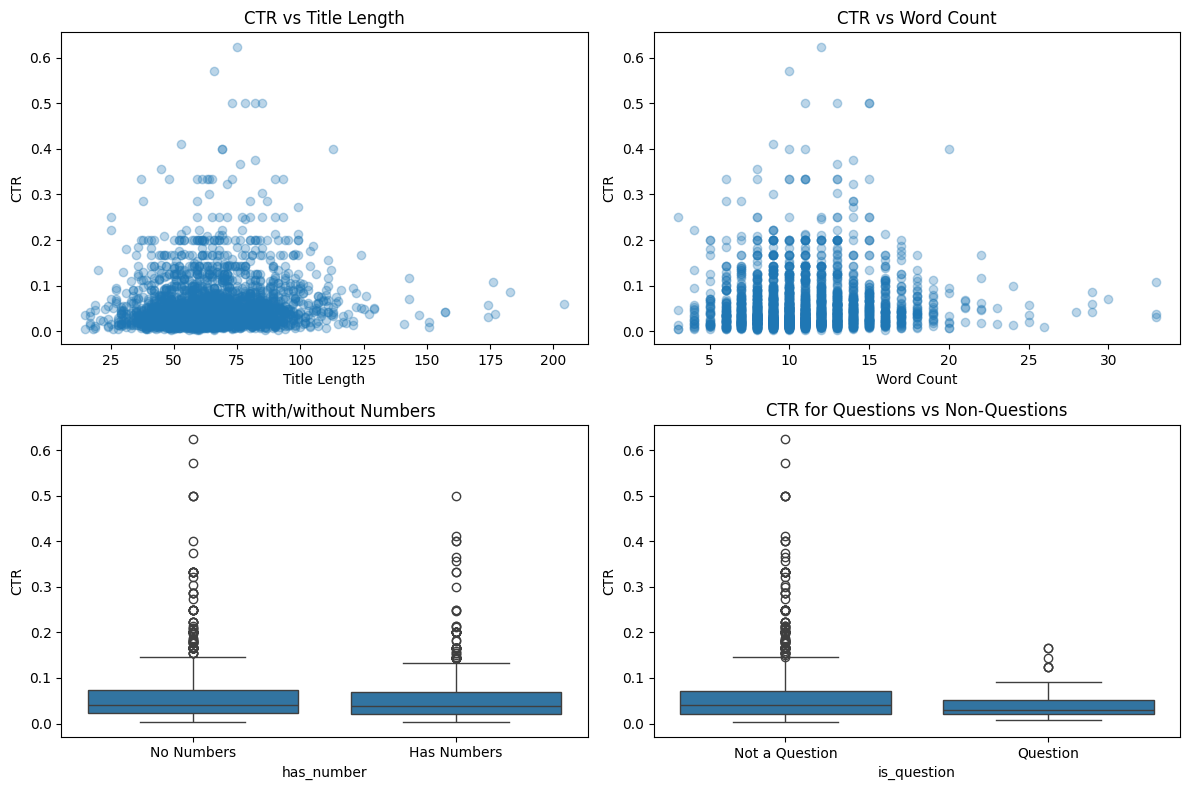

In [36]:
# Visualize key features
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# 1. CTR by title length
axes[0, 0].scatter(articles_with_metadata["title_length"], articles_with_metadata["ctr"], alpha=0.3)
axes[0, 0].set_title("CTR vs Title Length")
axes[0, 0].set_xlabel("Title Length")
axes[0, 0].set_ylabel("CTR")

# 2. CTR by word count
axes[0, 1].scatter(articles_with_metadata["word_count"], articles_with_metadata["ctr"], alpha=0.3)
axes[0, 1].set_title("CTR vs Word Count")
axes[0, 1].set_xlabel("Word Count")
axes[0, 1].set_ylabel("CTR")

# 3. CTR with/without numbers
sns.boxplot(x="has_number", y="ctr", data=articles_with_metadata, ax=axes[1, 0])
axes[1, 0].set_title("CTR with/without Numbers")
axes[1, 0].set_xticklabels(["No Numbers", "Has Numbers"])
axes[1, 0].set_ylabel("CTR")

# 4. CTR for questions vs non-questions
sns.boxplot(x="is_question", y="ctr", data=articles_with_metadata, ax=axes[1, 1])
axes[1, 1].set_title("CTR for Questions vs Non-Questions")
axes[1, 1].set_xticklabels(["Not a Question", "Question"])
axes[1, 1].set_ylabel("CTR")

plt.tight_layout()
plt.savefig("headline_features_vs_ctr.png")
plt.show()

In [37]:
# Statistical tests for binary features
from scipy import stats

for feature in ["has_number", "is_question"]:
    group0 = articles_with_metadata[articles_with_metadata[feature] == 0]["ctr"]
    group1 = articles_with_metadata[articles_with_metadata[feature] == 1]["ctr"]
    
    if len(group0) > 0 and len(group1) > 0:
        t_stat, p_val = stats.ttest_ind(group0, group1, equal_var=False)
        
        print(f"\nT-test for {feature}:")
        print(f"Mean CTR without feature: {group0.mean():.4f}")
        print(f"Mean CTR with feature: {group1.mean():.4f}")
        print(f"Percent difference: {((group1.mean() / group0.mean()) - 1) * 100:.1f}%")
        print(f"t-statistic: {t_stat:.4f}, p-value: {p_val:.6f}")
        print("Statistically significant" if p_val < 0.05 else "Not statistically significant")

# Save the clean dataset for future use
clean_article_ctr.to_csv("clean_article_ctr.csv", index=False)
articles_with_metadata.to_csv("articles_with_metadata.csv", index=False)

print("\nAnalysis complete. Clean datasets saved for future use.")


T-test for has_number:
Mean CTR without feature: 0.0610
Mean CTR with feature: 0.0550
Percent difference: -9.8%
t-statistic: 2.2971, p-value: 0.021739
Statistically significant

T-test for is_question:
Mean CTR without feature: 0.0596
Mean CTR with feature: 0.0429
Percent difference: -27.9%
t-statistic: 3.7628, p-value: 0.000301
Statistically significant

Analysis complete. Clean datasets saved for future use.


1. Avoiding questions gives the most noticeable CTR bump (~28% improvement),

2. Avoiding numbers gives a smaller lift (~10% improvement),

These aren't guarantees, but they are nudges—helpful when optimizing at scale or training an agent. Clear, informative, non-question headlines,

This is about building a closed feedback loop between:

- Data-driven content evaluation

- Prompt generation

- Agent behavior

- User interaction to optimize performance over time.

To improve CTR in lower-performing categories while maintaining balance, I'd recommend several evidence-based strategies based on the patterns we've seen in your data.

## Strategies for Improving CTR in Lower-Performing Categories

### 1. Category-Specific Headline Optimization

Different categories respond to different headline techniques:

- *News/Politics (typically lower CTR)*: Add specificity and authority signals
  - Example: "Local Council Votes on Tax Plan" → "City Council Approves 3% Tax Cut: What It Means for Your Neighborhood"

- *Health (often middle CTR)*: Focus on actionable, personal benefits
  - Example: "New Study on Sleep Patterns" → "5 Sleep Habits That Could Add Years to Your Life, According to New Research"

- *Entertainment/Sports (usually higher CTR)*: Leverage emotion and timeliness
  - Example: "Basketball Team Wins Game" → "Last-Second Shot Stuns Rivals as Team Clinches Playoff Spot"

### 2. Apply High-CTR Techniques to Low-CTR Categories

Based on your EDA, certain headline characteristics consistently drive higher CTR:

- *Add numbers where appropriate*: Numbers create specificity and promise structured content
  - For finance articles: "Market Update" → "7 Stocks That Jumped 15% Despite Market Downturn"

- *Ask questions in headlines*: Questions engage readers' curiosity
  - For technology articles: "New Privacy Settings Released" → "Is Your Phone Secretly Sharing Your Location? New Settings You Need to Check"

- *Use power words strategically*: Certain words trigger emotional responses
  - For policy articles: "Environmental Regulation Changed" → "Landmark Environmental Protection Revealed: How It Affects Your Community"

### 3. Length Optimization by Category

Different categories may have different optimal headline lengths:

- For complex topics (economics, science), slightly longer headlines that provide context may perform better
- For entertainment and sports, shorter, punchier headlines might work best

### 4. Maintain Editorial Standards

While optimizing for CTR, maintain category-appropriate standards:

- *News/Politics*: Prioritize accuracy and clarity over clickbait tactics
- *Finance/Science*: Ensure technical accuracy while making content accessible
- *Health/Wellness*: Avoid exaggerated claims while highlighting reader benefits

### 5. A/B Testing Framework

Implement a systematic testing approach:

1. Identify baseline CTR for each category
2. Apply category-specific optimizations
3. Measure improvement against baseline
4. Continuously refine based on results

### 6. Balance CTR with Quality Metrics

Consider multiple success metrics beyond just CTR:

- *Engagement time*: Do readers actually read the article after clicking?
- *Social shares*: Do readers find the content valuable enough to share?
- *Return rate*: Do readers come back for more content in this category?

### 7. Cross-Category Learning

Document which tactics work for high-performing categories and adapt them for lower-performing ones while maintaining the appropriate tone and style for each category.

### Implementation Plan

1. *Category Analysis*: First, thoroughly document baseline CTR by category
2. *Feature Importance*: Identify which headline features matter most in each category
3. *Strategy Matrix*: Create a category-specific strategy matrix based on your findings
4. *Balanced Optimization*: Apply these strategies with a focus on maintaining editorial quality
5. *Continuous Feedback*: Measure and iterate based on performance

This approach should help improve CTR in lower-performing categories while maintaining appropriate editorial balance across your content.